# Lab -- Growing Dataset with Active (Machine) Learning

Intended to accompany the lecture on Growing or Compressing Datasets, this notebook contains exercises to build labeled training datasets for binary classification through active learning.

You may find it helpful to first install the following dependencies:

In [16]:
!python3.10 -m pip install faiss-cpu pyarrow pandas matplotlib scikit-learn torch tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-ma

In [2]:
import os
import time
import random
from glob import glob
from datetime import datetime
from typing import List, Tuple, Optional, Callable

import faiss
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from IPython.display import Image, display, clear_output

# Section 1: 1D Classifier

First, let's go through the toy 1D example from lecture.

In [5]:
# Generate random data for two classes
np.random.seed(2)
x1 = np.random.normal(-2, 1, 100)
x2 = np.random.normal(2, 1, 100)
boundary = 0
seed = np.array([(boundary + 2 + (random.random() * 2)),
                 (boundary - 2 - (random.random() * 2))])
x = np.concatenate([seed, x1, x2])
labeled_0 = np.arange(len(seed))


# This is a simple case, so labeling is easy and cheap.
# But this isn't the case in practice. A real 'label' function would
# request information from humans or an expensive process.
def label(example):
    return int(example > boundary)


# Helper functions for plotting
def color(label):
    return 'r' if label else 'b'


def plot_boundary(ax):
    ax.axvline(x=boundary, color='gray', linestyle='--')


def plot_labeled(ax, x, labeled, labels):
    ax.scatter(x, np.zeros(len(x)), c='gray', alpha=0.2)
    ax.scatter(x[labeled], np.zeros(len(labeled)), c=[color(l) for l in labels], s=200, alpha=0.5)
    ax.axvline(x=boundary, color='gray', linestyle='--')
    ax.set_axis_off()

## Passive Learning (Random Sampling)
Passive learning simply samples unlabeled examples at random. It doesn't adapt to the model or the data, so we have to hope that we get examples that help us close in on the decision boundary.

In the figures below, gray dots represent unlabeled examples, red & blue dots represent the labeled examples for the two classes, and the dashed gray line is the actual decision boundary.

In [6]:
def passive_selection(x, labeled, label_func, n):
    candidates = set(range(0, len(x))) - set(labeled)
    labeled = np.concatenate([labeled, random.sample(list(candidates), n)])
    labels = [label_func(example) for example in x[labeled]]
    return labeled, labels

Round 0: 2 labeled examples


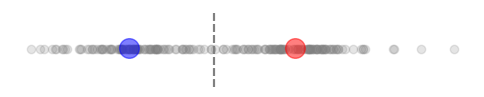

Round 1: 3 labeled examples


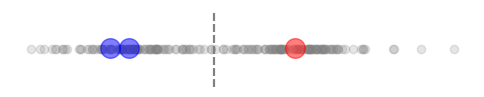

Round 2: 4 labeled examples


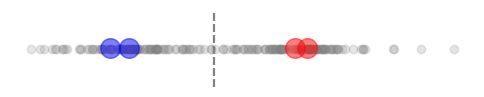

Round 3: 5 labeled examples


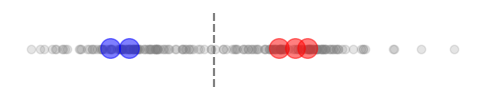

Round 4: 6 labeled examples


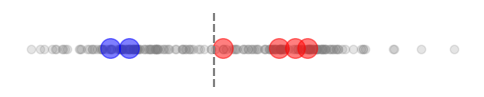

Round 5: 7 labeled examples


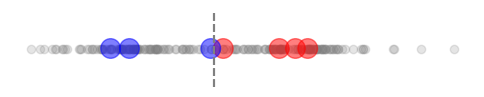

Round 6: 8 labeled examples


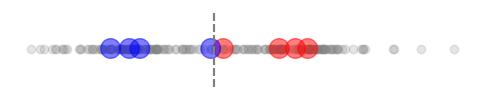

Round 7: 9 labeled examples


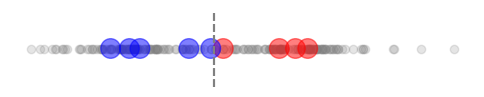

In [7]:
n = 8
labeled, labels = passive_selection(x, labeled_0, label, n)
for i in range(n):
    print(f"Round {i}: {2+i} labeled examples")
    fig, ax = plt.subplots(1, 1, figsize=(6, 1))
    plot_labeled(ax, x, labeled[:2+i], labels[:2+i])
    plot_boundary(ax)
    plt.show()

## Exercise 1: Active Learning (Max Entropy)
Active learning trains a model $A_r$ after every example $\mathbf{x}$ (or batch of examples) is labeled and leverages that model to select the following example. For instance, we can quantify the model's uncertainty by calculating the entropy for each of the pool of unlabeled examples $\mathcal{P}_r$ based on the model's predicted probabilities:

$$\phi_{\text{Ent}}(\mathbf{x}, A_r) = - \sum_{\hat{y}} P(\hat{y}|\mathbf{x}; A_r) \log P(\hat{y}|\mathbf{x}; A_r)$$

and select the examples with the highest entropy:

$$argmax_{\mathbf{x} \in \mathcal{P}_r} \phi_{\text{Ent}}(\mathbf{x}, A_r, \mathcal{P}_r)$$

In [8]:
labeled_0

array([0, 1])

In [9]:
def select_max_entropy(x, model, indices: List[int], budget: int):
    # Get prediction probability for elegible indices
    proba = model.predict_proba(x[indices].reshape(-1, 1))

    # Calculate information entropy from probabilities
    entropy = -1.0 * (np.log(proba) * proba).sum(axis=1)

    # Select indices with highest entropy (i.e. MaxEnt)
    selected = entropy.argsort(axis=0)[::-1][:budget]

    # Convert to original index
    selected = np.array(indices)[selected]

    return selected

In this exercise, you'll leverage this max entropy heuristic to actively select examples to label! You should implement the active learning loop from lecture with a `linear_model.LogisticRegression()` as the classifier. This should effectively perform binary search to find the decision boundary. You just need to fill in the section below marked `YOUR CODE HERE`.

In [10]:
def active_selection(x, labeled, label_func, n):
    labels = [label_func(example) for example in x[labeled]]
    candidates = set(np.arange(len(x))) - set(labeled)
    # YOUR CODE HERE
    
    # loop n times
    for _ in range(n):
        # train model: input X[m(number), n(feature)], output y[m(label)]
        model  = linear_model.LogisticRegression().fit(
            x[labeled].reshape(-1,1), np.array(labels)
        )
        
        # select max entropy sample
        selected = select_max_entropy(x, model, list(candidates), budget=1)
        idx = int(np.asarray(selected).ravel()[0])
        
        # label selected sample and add to labeled set
        labels.append(label_func(x[idx]))
        labeled = np.append(labeled, idx)
        
        # remove idx from candidates
        candidates.remove(idx)
        

    return labeled, labels

Let's put your active selection process into action! In the figures below, gray dots represent unlabeled examples, red & blue dots represent the labeled examples for the two classes, and the dashed gray line is the actual decision boundary. Rounds 1+ will show the results of your active learning implementation. How does it compare to the passive approach?

Round 0: 2 labeled examples


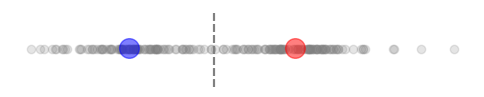

Round 1: 3 labeled examples


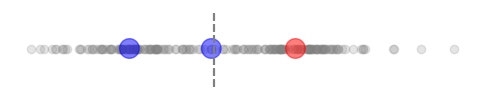

Round 2: 4 labeled examples


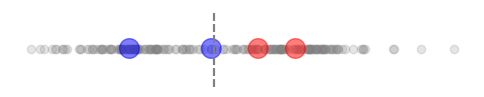

Round 3: 5 labeled examples


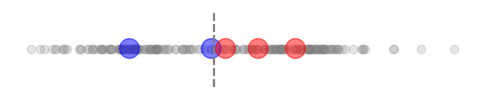

Round 4: 6 labeled examples


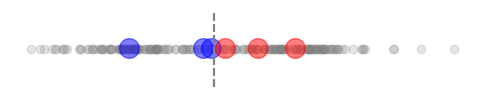

Round 5: 7 labeled examples


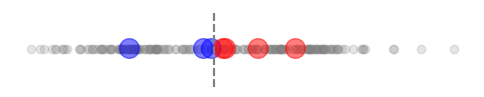

Round 6: 8 labeled examples


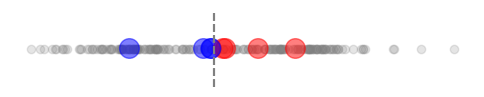

Round 7: 9 labeled examples


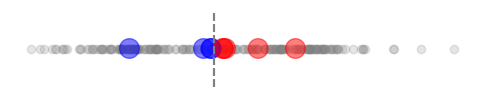

In [11]:
n = 8
labeled, labels = active_selection(x, labeled_0, label, n)
for i in range(n):
    print(f"Round {i}: {2+i} labeled examples")
    fig, ax = plt.subplots(1, 1, figsize=(6, 1))
    plot_labeled(ax, x, labeled[:2+i], labels[:2+i])
    plot_boundary(ax)
    plt.show()

# Section 2: OpenImages

Let's scale up active learning to a real dataset, [OpenImages](https://storage.googleapis.com/openimages/web/index.html)! The OpenImages dataset has over 8 million images from Flickr and captures tens of thousands of classes. To make this manageable for our lab assignment, we will train a `LogisticRegression()` classifier on top of pre-computed embeddings for the available images. Please download and unpack the embeddings.

1. [Download embeddings](https://drive.google.com/file/d/1HLEI7OWDGfP-__w6vlnZjgOCo5fshP-7/view?usp=sharing) (~18 GB)
2. Unpack embeddings: `tar -xvf data.tar.gz`

In [3]:
# Assuming you unpacked the data in the same directory
# as this notebook, you shouldn't need to change this.
# !gdown --id 1HLEI7OWDGfP-__w6vlnZjgOCo5fshP-7 --output data.tar.gz
metadata_dir='data/saved_metadata/'
train_dir='data/saved_embeddings/train/'
test_dir='data/saved_embeddings/test/'

In [ ]:
# !curl -H "Authorization: Bearer YOUR_TOKEN" https://www.googleapis.com/drive/v3/files/1HLEI7OWDGfP-__w6vlnZjgOCo5fshP-7?alt=media -o data.tar.gz
# !curl -L -o data.tar.gz "https://drive.usercontent.google.com/download?id=1HLEI7OWDGfP-__w6vlnZjgOCo5fshP-7&export=download&authuser=0&confirm=t&uuid=fe32ea3e-d7d3-4cc4-8b58-5a2a2dd6a877&at=ALWL0p60MmX6-vISXEKeo7dwzXDn:1763005035037"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   507    0   507    0     0   3647      0 --:--:-- --:--:-- --:--:--  3673


In [23]:
!tar -xvf data.tar.gz


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


## Loading Data

Don't worry about understanding all of this. You'll only use a small part of this class in the exercise below.

In [4]:
class OpenImagesDataset(Dataset):
    def __init__(self,
                 metadata_dir: str,
                 embeddings_dir: str,
                 embeddings_include: str = '*.parquet.gzip',
                 target_class: str = "Sushi",
                 split: str ='train'):

        # Save attributes
        self._metadata_dir = metadata_dir
        self._embeddings_dir = embeddings_dir
        self._embeddings_include = embeddings_include
        self._target_class = target_class

        # Define paths of metadata files
        assert split in ['train', 'test'], 'Invalid value for split'
        label_path = os.path.join(metadata_dir, 'oidv6-class-descriptions.csv')
        data_path = None
        url_path = None

        if split == 'train':
            data_path = os.path.join(
                metadata_dir,
                'oidv6-train-annotations-human-imagelabels.csv')
            url_path = os.path.join(
                metadata_dir,
                'oidv6-train-images-with-labels-with-rotation.csv')

        elif split == 'test':
            data_path = os.path.join(
                metadata_dir,
                'test-annotations-human-imagelabels.csv')
            url_path = os.path.join(
                metadata_dir,
                'test-images-with-rotation.csv')

        # Load metadata
        self.split = split
        print('Loading metadata...', end=' ')
        # We use the following code to get label_name. To avoid memory overflow, we hardcode the label_name.
        # self._label_df = pd.read_csv(label_path)
        # label_name = self._label_df.query(f"DisplayName == '{label}'")[
        #     'LabelName'].to_list()[0]
        label_name = "/m/07030"
        labels_path = f"./{split}_labels.parquet"
        if os.path.exists(labels_path):
            # Load from cache if exists
            self._labels_df = pd.read_parquet(labels_path)
            print(f"Loaded cached labels from {labels_path}")

        else:

            # Read only necessary columns
            _data_df = pd.read_csv(data_path, usecols=['ImageID', 'LabelName', "Confidence"])

            # Filter before any operations
            _data_df = _data_df[_data_df['LabelName'] == label_name]

            # Set index after filtering to work with smaller dataset
            _data_df.set_index('ImageID', inplace=True)

            # Read only required columns from URL file
            _url_df = pd.read_csv(url_path, usecols=['ImageID', 'OriginalURL'])
            _url_df.set_index('ImageID', inplace=True)

            # Join with URL data
            self._labels_df = _data_df.join(_url_df, on='ImageID', how='left')
            self._labels_df.to_parquet(labels_path)

            del _data_df, _url_df
            import gc
            gc.collect()

        # Rename columns and reset index
        self._labels_df.reset_index(inplace=True)
        self._labels_df.rename(columns={'OriginalURL': 'img_path'}, inplace=True)
        self._labels_df.set_index('img_path', inplace=True)

        print(self._labels_df.shape)

        # Load embeddings
        self._load_embeddings_df()
        print('Done.')


    def to_numpy(self):
        """
        Returns embeddings and labels   
        Important: does not make a copy of the data in memory
        """
        return self.embeddings, self.labels

    @property
    def target_class(self):
        return self._target_class

    @property
    def urls(self):
        return self._embeddings_df.index.values

    @property
    def labels(self):
        return self._labels_df.Confidence.values

    @property
    def index(self):
        return self._embeddings_df.index.values

    @property
    def embeddings(self):
        return self._embeddings_df.values

    @property
    def embeddings_dimension(self):
        return self._embeddings_df.shape[1]

    def _load_embeddings_df(self):
        """
        Loads embeddings from partitions in embeddings_dir with specified
        pattern. Each embedding value is loaded into a separate column
        such that embeddings.values returns the array necessary for
        inference, which avoids creating a copy in memory of the data
        """
        # Get paths of dfs in embeddings_dir with pattern
        pattern = os.path.join(self._embeddings_dir,
                               self._embeddings_include)
        filepaths_ls = glob(pattern, recursive=True)
        filepaths_ls.sort()

        # Store all embedding values and indices
        index_ls = []
        values_ls = []
        wrapped_loader = tqdm(filepaths_ls,
                              desc="Loading embeddings",
                              unit="partition")
        for filepath in wrapped_loader:
            import gc
            gc.collect()
            label_path = self.split + "_" + filepath.replace('/', '_')
            # Read only necessary columns
            if os.path.exists(label_path):
                df = pd.read_parquet(label_path)
                # print(df.index)
                index_ls.extend(df.index)
                values_ls.append(df['embedding'].tolist())
            else:
                df = pd.read_parquet(filepath, columns=['embedding'])

                # Get intersection of indices before loading full data
                common_indices = df.index.intersection(self._labels_df.index)
                # print(len(common_indices))
                if len(common_indices) > 0:
                    # Filter using pre-computed common indices
                    relevant_df = df.loc[common_indices]
                    relevant_df.to_parquet(label_path)

                    index_ls.extend(common_indices)
                    values_ls.append(relevant_df['embedding'].tolist())

                # Explicitly delete dataframes to free memory
            del df
            if 'relevant_df' in locals():
                del relevant_df

        # np.concatenate(index_ls, axis=0)
        # np.concatenate(values_ls, axis=0, dtype=np.float32)
        # Join into single df and store
        self._embeddings_df = pd.DataFrame(
            data=np.concatenate(values_ls, axis=0, dtype=np.float32),
            index=index_ls)
        # print(self._embeddings_df.values)
        self._labels_df = self._labels_df.reindex(self._embeddings_df.index, fill_value=0)

    """
    Necessary for pytorch
    """
    def __len__(self):
        return len(self._embeddings_df)

    def __getitem__(self, idx: int):
        return (self._embeddings_df.iloc[idx].values,
                self._labels_df.Confidence.iloc[idx])


def create_dataset(metadata_dir: str, embeddings_dir: str, split: str):
    return OpenImagesDataset(metadata_dir, embeddings_dir, split=split)

In [5]:
# Create test dataset object
if 'd_test' not in locals():
    d_test = create_dataset(metadata_dir, test_dir, 'test')
print("Shape of embeddings for test images: {}".format(d_test.embeddings.shape))

Loading metadata... Loaded cached labels from ./test_labels.parquet
(190, 3)


Loading embeddings:   0%|          | 0/16 [00:00<?, ?partition/s]

Done.
Shape of embeddings for test images: (162, 256)


In [6]:
# Create training dataset object
# del d_train
# import gc
# gc.collect()
# dir()
if 'd_train' not in locals():
    d_train = create_dataset(metadata_dir, train_dir, 'train')
print()
print("Shape of embeddings for training images: {}".format(d_train.embeddings.shape))

Loading metadata... Loaded cached labels from ./train_labels.parquet
(2427, 3)


Loading embeddings:   0%|          | 0/94 [00:00<?, ?partition/s]

Done.

Shape of embeddings for training images: (2172, 256)


## Helper functions for active learning
Don't worry about understanding this to complete the exercise.

In [7]:
def set_random_seed(seed: Optional[int] = None):
    seed = np.random.randint(10000) if seed is None else seed
    np.random.seed(seed)
    return seed


def create_seed(labels: np.array,
                emb_dimension: int,
                npositive: int = 5,
                nnegative: int = 95,
                random_seed: int = 400):
    # Make sure there are enough negative examples
    nnegative = max(nnegative, emb_dimension - npositive)

    # Select indices for random samples
    pos_samples = np.random.choice(
        np.where(labels == 1)[0], npositive, replace=False)
    neg_samples = np.random.choice(
        np.where(labels == 0)[0], nnegative, replace=False)

    # Combine and sort
    seed = np.sort(np.concatenate((pos_samples, neg_samples)))

    return seed


def visualize_urls(urls: List[str], message: str = ''):
    print(message)
    [display(Image(url=url, width=400)) for url in urls]
    input('Press any key to continue')
    clear_output()


def train_model(embeddings: np.array, labels: np.array):
    return LogisticRegression().fit(embeddings, labels)


def eval_model(model, dataset):
    proba = model.predict_proba(dataset.embeddings)[:, 1]
    return average_precision_score(dataset.labels, proba)


def collect_labels(dataset, indices: np.array, target_class: str):
    labels = []
    for url in dataset.urls[indices]:

        # Show link and image
        clear_output()
        print(f'Link: {url}')
        display(Image(url=url, width=400))
        time.sleep(0.25)

        # Get user label
        need_input = True
        while need_input:
            label = input(f'Is this an example of {target_class}? [Y/n] ')
            label = 'Y' if label is None or label == '' else label[0].upper()

            if label not in ['N', 'Y']:
                print('Invalid input')
                continue

            labels.append(1 if label == 'Y' else 0)
            need_input = False

    clear_output()
    print(f'Finished labeling {len(labels)} images')
    return labels


def visualize_scores(scores: List[float], ylabel: str = 'Average precision'):
    plt.title('Model score for test data')
    plt.xlabel('Active learning round (#)')
    plt.ylabel(ylabel)

    plt.plot(range(len(scores)), scores, 'o-', color='b')
    plt.xticks(range(len(scores)))
    plt.legend(loc="best")
    plt.show()

def select_maxent(model, dataset, indices: List[int], budget: int):
    # Get prediction probability for elegible indices
    proba = model.predict_proba(dataset.embeddings[indices])

    # Calculate information entropy from probabilities
    entropy = -1.0 * (np.log(proba) * proba).sum(axis=1)

    # Select indices with highest entropy (i.e. MaxEnt)
    selected = entropy.argsort(axis=0)[::-1][:budget]

    # Convert to original index
    selected = np.array(indices)[selected]

    return selected

## Baseline approach for reference
You might want to skip this if you're in a rush ;)

In [8]:
def baseline_selection(
    train, test, concept: str, rounds: Tuple[int],
    npos: int = 5, nneg: int = 95, k: int = 100,
    select: Callable = select_maxent):

    # Set initial values
    labeled = create_seed(train.labels, train.embeddings_dimension, npos, nneg)
    new_labeled = labeled
    labels = train.labels[labeled]
    scores = []
    model = None
    candidates = set(np.arange(len(train))) - set(labeled)

    # Visualize seed
    visualize_urls(train.urls[labeled[np.where(labels == 1)]],
                   message=f'Initial positive samples for {concept}')

    # Main active learning loop
    for budget in rounds:
        # Train model using labeled samples and score
        model = train_model(train.embeddings[labeled], labels)
        scores.append(eval_model(model, test))

        # Select points to label (MaxEnt for now)
        new_labeled = select(model, train, list(candidates), budget)

        # User labels selected points
        new_labels = collect_labels(train, new_labeled, concept)

        # Update arrays
        labeled = np.concatenate((labeled, new_labeled))
        labels = np.concatenate((labels, new_labels))
        candidates -= set(new_labeled)

    # Train and score final iteration of model
    model = train_model(train.embeddings[labeled], labels)
    scores.append(eval_model(model, test))
    return model, scores

In [9]:
# Set rare concept (e.g. Bowling, Sushi, Rat, Beach, Hawk, Cupcake, Crowd, etc)
concept = 'Sushi'

# Set concept
# d_train.target_class = concept
# d_test.target_class = concept

In [10]:
np.random.seed(400)  # for reproducibility
start = datetime.now()
model, scores = baseline_selection(
    train=d_train, test=d_test, concept=concept, npos=5, nneg=300,
    rounds=[5, 5, 5], select=select_maxent)
print("Total time: {}".format(datetime.now() - start))

Finished labeling 5 images
Total time: 0:00:50.466768


/var/folders/f7/chy8r0p10x14zsxsjfxjmnx80000gn/T/ipykernel_68863/1333845570.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


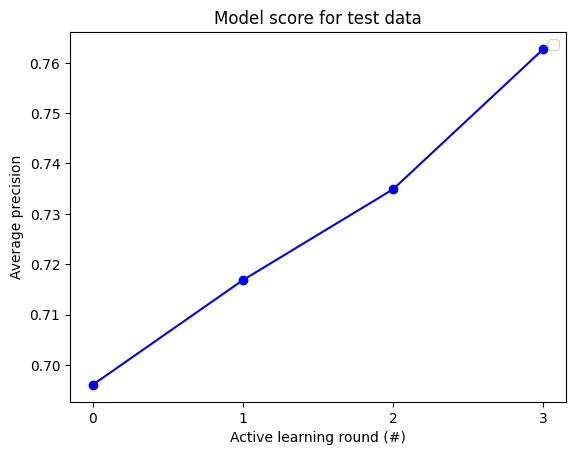

In [11]:
visualize_scores(scores)

## Similarity Search for Efficient Active Learning and Search (SEALS)
That was really slow. Let's speed up the process by implementing the [SEALS](https://aaai-2022.virtualchair.net/poster_aaai12967) approach from lecture.

First, we need to create a similarity search index:

In [12]:
class IndexWrapper():

    def __init__(self, dataset, method='LSH'):
        assert method in ['LSH', 'flatL2'], 'Invalid index method'
        self._dataset = dataset
        self._method = method
        self._index = self._create_index()

    def __len__(self):
        return self._index.ntotal

    def __getitem__(self, idx: int):
        # Return url and corresponding embedding
        return self._dataset.index[idx], self._dataset.embeddings[idx]

    @property
    def d(self):
        return self._index.d

    @property
    def ntotal(self):
        return self._index.ntotal

    def _create_index(self):
        """
        Returns FAISS index created from dataset.embeddings using the
        specified index method
        """
        # Initialize index
        index = None
        d = self._dataset.embeddings_dimension

        if self._method == 'flatL2':
            index = faiss.IndexFlatL2(d)

        elif self._method == 'LSH':
            n_bits = 2 * d
            index = faiss.IndexLSH(d, n_bits)
            index.train(self._dataset.embeddings)

        # Add embeddings
        index.add(self._dataset.embeddings)

        return index

    def search(self, q: np.array, k: int, attrs=None):
        """
        Returns tuple, where each element is an attribute array specified
        in attrs. Valid attributes include 'distances', 'urls', 'indices', and
        'embeddings'
        """
        # If no attributes selected, use default
        default_attrs = ('indices', 'distances')
        attrs = default_attrs if attrs is None else attrs

        # Initialize results dictionary
        results = {}

        # Convert query to 2D np array for FAISS index
        q = q if len(q.shape) == 2 else np.array([q])

        # Search k-NN of q using the index
        nn_distances, nn_indices = self._index.search(q, k)
        results['distances'], results['indices'] = nn_distances, nn_indices

        # Get other attributes
        other_attrs = [attr for attr in attrs if attr not in default_attrs]
        for attr in other_attrs:
            assert hasattr(self._dataset, attr), 'Invalid attribute'
            results[attr] = [
                getattr(self._dataset, attr)[idx] for idx in results['indices']]

        # Return results in order given by attrs
        return tuple([results[attr] for attr in attrs])


def create_index(dataset, method: str = 'LSH'):
    return IndexWrapper(dataset, method=method)

In [13]:
# Create IndexWrapper for training data
if 'index_train' not in locals():
    index_train = create_index(d_train)

## Exercise 2: Manage Candidate Pool
Now that we have a similarity search index let's use it to limit the candidate pool we select unlabeled examples from. We don't need to look at all the unlabeled examples from the beginning. Instead, we could start with the nearest neighbors to our currently labeled examples and expand the pool. Using the baseline approach as a starting point, fill in the sections of the code labeled `YOUR CODE HERE`.

In [14]:
def SEALS(
    train, test, concept: str, rounds: Tuple[int],
    npos: int = 5, nneg: int = 95, k: int = 100,
    select: Callable = select_maxent, knn = None):

    # Set initial values
    labeled = create_seed(train.labels, train.embeddings_dimension, npos, nneg)
    new_labeled = labeled
    labels = train.labels[labeled]
    scores = []
    model = None
    candidates = set(np.arange(len(train))) - set(labeled)

    if knn is not None:
        # 当前已标注中的正例索引（相对于整个训练集）
        pos_idx = labeled[np.where(labels == 1)]
        if len(pos_idx) > 0:
            # 取每个正例的 k 个近邻；knn.search 默认返回 (indices, distances)
            nn_indices, _ = knn.search(train.embeddings[pos_idx], k)
            # 并集去重，并排除已标注
            candidates = set(np.unique(nn_indices).tolist()) - set(labeled)
        else:
            # 兜底：如果暂时没有正例，就退回到全量未标注
            candidates = set(np.arange(len(train))) - set(labeled)

    # Visualize seed
    visualize_urls(train.urls[labeled[np.where(labels == 1)]],
                   message=f'Initial positive samples for {concept}')

    # Main active learning loop
    for budget in rounds:
        if knn is not None:
            pos_idx = labeled[np.where(labels == 1)]
            if len(pos_idx) > 0:
                nn_indices, _ = knn.search(train.embeddings[pos_idx], k)
                candidates = set(np.unique(nn_indices).tolist()) - set(labeled)
                # 如果你想在近邻基础上保留上一轮的候选，可以用下面这一行代替上一行：
                # candidates = (candidates | set(np.unique(nn_indices).tolist())) - set(labeled)
            else:
                candidates = set(np.arange(len(train))) - set(labeled)

        # Train model using labeled samples and score
        model = train_model(train.embeddings[labeled], labels)
        scores.append(eval_model(model, test))

        # Select points to label (MaxEnt for now)
        new_labeled = select(model, train, list(candidates), budget)

        # User labels selected points
        new_labels = collect_labels(train, new_labeled, concept)

        # Update arrays
        labeled = np.concatenate((labeled, new_labeled))
        labels = np.concatenate((labels, new_labels))
        candidates -= set(new_labeled)

    # Train and score final iteration of model
    model = train_model(train.embeddings[labeled], labels)
    scores.append(eval_model(model, test))
    return model, scores

In [15]:
np.random.seed(400)  # for reproducibility
start = datetime.now()
model, scores = SEALS(
    train=d_train, test=d_test, concept=concept, npos=5, nneg=300,
    rounds=[5, 5, 5], select=select_maxent, knn=index_train)
print("Total time: {}".format(datetime.now() - start))

Finished labeling 5 images
Total time: 0:00:35.086361


/var/folders/f7/chy8r0p10x14zsxsjfxjmnx80000gn/T/ipykernel_68863/1333845570.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


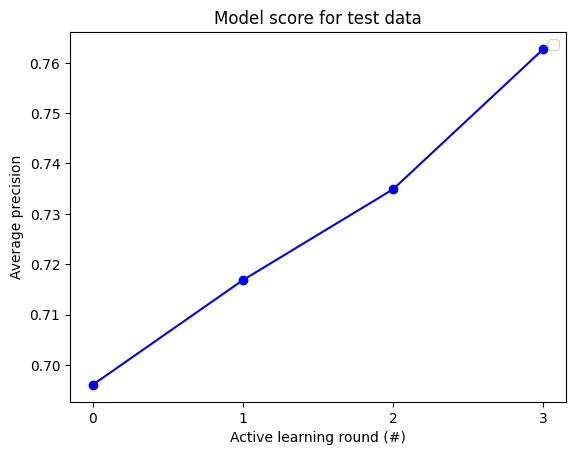

In [16]:
visualize_scores(scores)